# GOOGL stock 'Close' value prediction

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM

## Stock data function configured to drop all columns except 'Open','High' and 'Close'

In [27]:
def get_stock_data(stock_name, normalized=0):
    
    url="http://www.google.com/finance/historical?q=%s&ei=u-lHWfGPNNWIsgHHqIqICw&output=csv" % stock_name 
    print(url)
    col_names = ['Date','Open','High','Low','Close','Volume']
    stock = pd.read_csv(url, header=0, names=col_names) 
    df = pd.DataFrame(stock)

    df["Volume"] = df["Volume"] / 10000
    df.drop(df.columns[[0,3,5]], axis=1, inplace=True) 
    return df

## Loading GOOGL stock data from yahoo.com

In [28]:
stock_name = 'GOOGL'
df = get_stock_data(stock_name,0)
df.head()

http://www.google.com/finance/historical?q=GOOGL&ei=u-lHWfGPNNWIsgHHqIqICw&output=csv


,Open,High,Close
0,941.95,953.13,951.00
1,930.98,944.66,940.81
2,925.00,936.14,927.69
3,924.20,936.29,932.26
4,933.22,934.24,919.46


## Saving the data to a file for a future use

In [29]:
today = datetime.date.today()
file_name = stock_name+'_stock_%s.csv' % today
df.to_csv(file_name)

In [30]:
df['High'] = df['High'] / 1000
df['Open'] = df['Open'] / 1000
df['Close'] = df['Close'] / 1000
df.head(5)

,Open,High,Close
0,0.94195,0.95313,0.95100
1,0.93098,0.94466,0.94081
2,0.92500,0.93614,0.92769
3,0.92420,0.93629,0.93226
4,0.93322,0.93424,0.91946


In [31]:
def ExpMovingAverage(values, window):
    weights = np.exp(np.linspace(-1.,0.,window))
    weights /= weights.sum()
    a = np.convolve(values,weights)[:len(values)]
    a[:window] = a[window]
    return a

df['ma_ratio'] =8 * ExpMovingAverage(df['Close'], 10) / ExpMovingAverage(df['Close'], 15)

In [32]:
def get_rsi_timeseries(prices, n=14):
    deltas = (prices-prices.shift(1)).fillna(0)
    avg_of_gains = deltas[1:n+1][deltas > 0].sum() / n
    avg_of_losses = -deltas[1:n+1][deltas < 0].sum() / n

    # Set up pd.Series container for RSI values
    rsi_series = pd.Series(0.0, deltas.index)

    # Now calculate RSI using the Wilder smoothing method, starting with n+1 delta.
    up = lambda x: x if x > 0 else 0
    down = lambda x: -x if x < 0 else 0
    i = n+1
    for d in deltas[n+1:]:
        avg_of_gains = ((avg_of_gains * (n-1)) + up(d)) / n
        avg_of_losses = ((avg_of_losses * (n-1)) + down(d)) / n
        if avg_of_losses != 0:
            rs = avg_of_gains / avg_of_losses
            rsi_series[i] = 100 - (100 / (1 + rs))
        else:
            rsi_series[i] = 100
        i += 1

    return rsi_series


# df['RSI'] = get_rsi_timeseries(df['Close'], n=14)
# a = np.array(df)
# df['RSI'] = a[:,df.columns.get_loc('RSI')][::-1]

In [33]:
df = df[['High','Open','Close']] 
# df = df[['Open','High','ma_ratio','RSI','Close']]  #
 #
df = df[:500]
# df['Close']=df['Close'] *6
# df['ma_ratio']=df['ma_ratio'] *6

df.head(5)

,High,Open,Close
0,0.95313,0.94195,0.95100
1,0.94466,0.93098,0.94081
2,0.93614,0.92500,0.92769
3,0.93629,0.92420,0.93226
4,0.93424,0.93322,0.91946


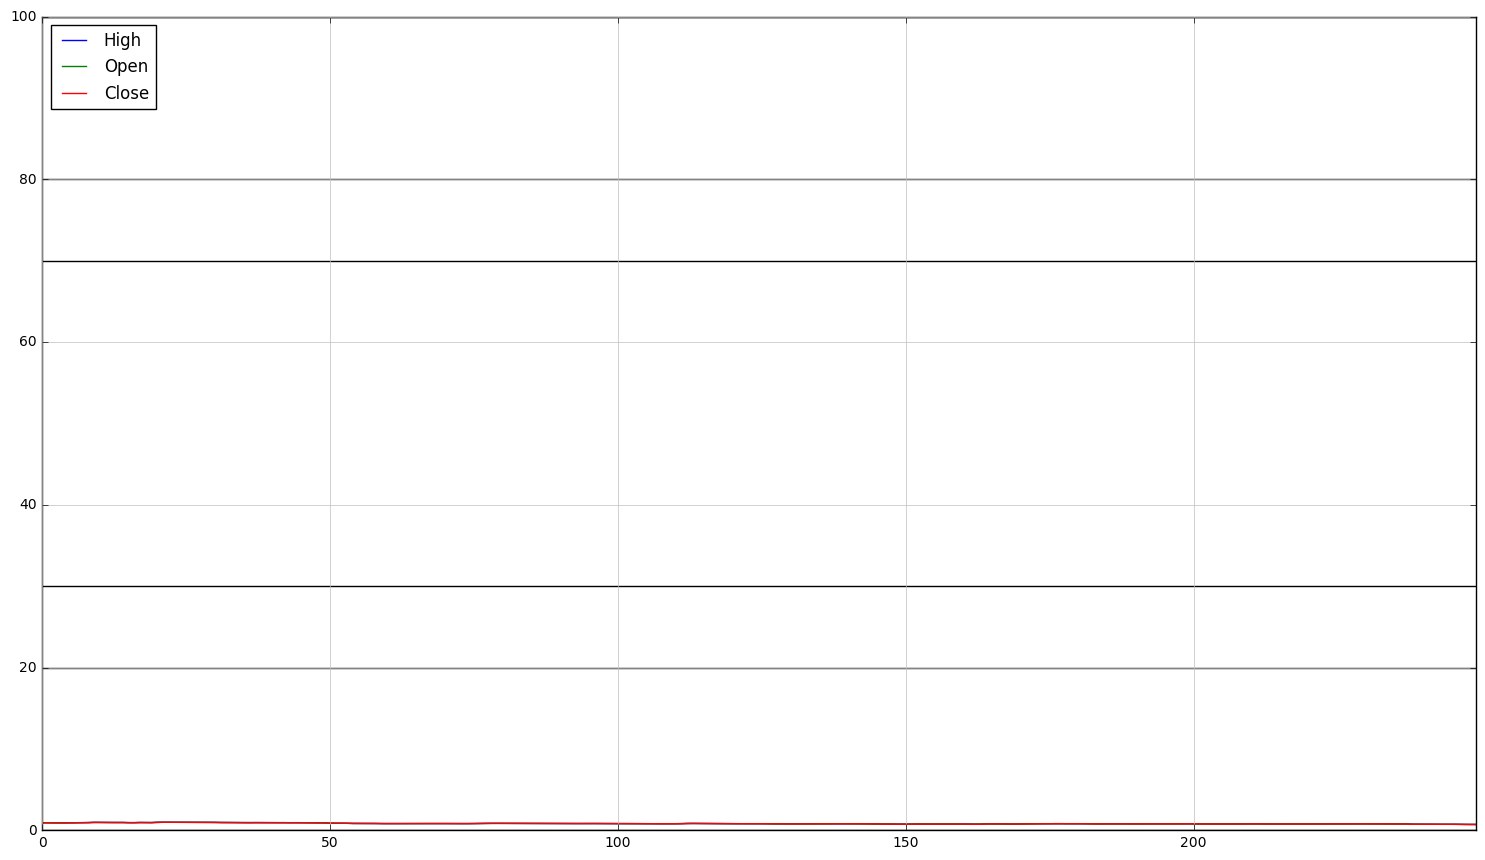

In [34]:
df.plot()

plt.plot([0, 350], [70, 70], color='k', linestyle='-', linewidth=1)
plt.plot([0, 350], [30, 30], color='k', linestyle='-', linewidth=1)
plt.plot([0, 350], [80, 80], color='k', linestyle='-', linewidth=1)
plt.plot([0, 350], [20, 20], color='k', linestyle='-', linewidth=1)
plt.plot([0, 350], [100, 100], color='k', linestyle='-', linewidth=1)
plt.plot([0, 350], [0, 0], color='k', linestyle='-', linewidth=1)


plt.grid(True,linestyle='-',color='0.75')
plt.legend(loc='upper left')
# plt2.figure(num=None, figsize=(80, 60), dpi=400, facecolor='w', edgecolor='k')
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
# fig.savefig(stock_name +'.png', dpi=1000)
plt.show()

## Updated load_data function from lstm.py, configured to accept any amount of features. It is set to calculate the last feature as a result.

In [35]:
def load_data(df, seq_len):
    amount_of_features = len(df.columns)
    data = df.as_matrix()
    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])

    result = np.array(result)
    row = 0.9 * result.shape[0]
    train = result[:int(row), :]
    x_train = train[:, :-1]
    y_train = train[:, -1][:,-1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1][:,-1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  

    return [x_train, y_train, x_test, y_test]

## Building model functions

In [36]:
def build_model(layers):
    model = Sequential()

    model.add(LSTM(
        input_dim=layers[0],
        output_dim=layers[1],
        return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(
        layers[2],
        return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(
        output_dim=layers[2]))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="adam",metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model

def build_model2(layers):
        d = 0.2
        model = Sequential()
        model.add(LSTM(128, input_shape=(layers[1], layers[0]), return_sequences=True))
        model.add(Dropout(d))
        model.add(LSTM(64, input_shape=(layers[1], layers[0]), return_sequences=False))
        model.add(Dropout(d))
        model.add(Dense(16,init='uniform',activation='relu'))        
        model.add(Dense(1,init='uniform',activation='relu'))
        model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
        return model

## Setting X and Y for training and testing

In [37]:
window = 5
X_train, y_train, X_test, y_test = load_data(df[::-1], window)
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (219, 5, 3)
y_train (219,)
X_test (25, 5, 3)
y_test (25,)


## Loading the model sequence structure

In [38]:
amount_of_features = len(df.columns)
# model = build_model([amount_of_features,lag,1])
model = build_model2([amount_of_features,window,1])

## Executing the model & RMS/RMSE results

In [39]:
model.fit(
    X_train,
    y_train,
    batch_size=512,
    nb_epoch=400,
    validation_split=0.1,
    verbose=1)

Train on 197 samples, validate on 22 samples
Epoch 1/400
197/197 [==============================] - 1s - loss: 0.6695 - acc: 0.0000e+00 - val_loss: 0.9213 - val_acc: 0.0000e+00
Epoch 2/400
197/197 [==============================] - 0s - loss: 0.6631 - acc: 0.0000e+00 - val_loss: 0.9135 - val_acc: 0.0000e+00
Epoch 3/400
197/197 [==============================] - 0s - loss: 0.6575 - acc: 0.0000e+00 - val_loss: 0.9047 - val_acc: 0.0000e+00
Epoch 4/400
197/197 [==============================] - 0s - loss: 0.6504 - acc: 0.0000e+00 - val_loss: 0.8958 - val_acc: 0.0000e+00
Epoch 5/400
197/197 [==============================] - 0s - loss: 0.6435 - acc: 0.0000e+00 - val_loss: 0.8857 - val_acc: 0.0000e+00
Epoch 6/400
197/197 [==============================] - 0s - loss: 0.6354 - acc: 0.0000e+00 - val_loss: 0.8737 - val_acc: 0.0000e+00
Epoch 7/400
197/197 [==============================] - 0s - loss: 0.6259 - acc: 0.0000e+00 - val_loss: 0.8599 - val_acc: 0.0000e+00
Epoch 8/400
197/197 [==========

In [40]:
trainScore = model.evaluate(X_train, y_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

testScore = model.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))

Train Score: 0.00 MSE (0.06 RMSE)
Test Score: 0.02 MSE (0.15 RMSE)


## Predictions vs Real results

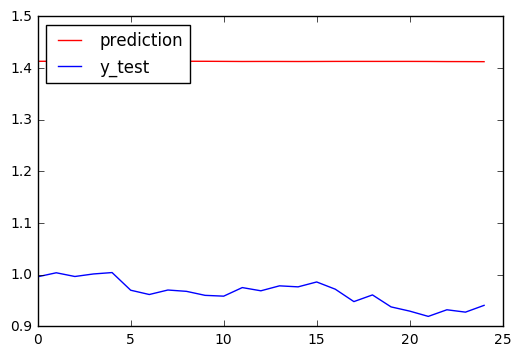

ratio mean 0.187976299408
ratio std 0.0297738393895
diff mean 0.152831167159
diff std 0.0242295753526


In [41]:
import matplotlib.pyplot as plt2

# print(X_test[-1])
diff=[]
ratio=[]
p = model.predict(X_test)
for u in range(len(y_test)):
    pr = p[u][0]
    ratio.append((y_test[u]/pr)-1)
    diff.append(abs(y_test[u]- pr))
    #print(u, y_test[u], pr, (y_test[u]/pr)-1, abs(y_test[u]- pr))

plt2.plot(p+0.6,color='red', label='prediction')
plt2.plot(y_test,color='blue', label='y_test')
plt2.legend(loc='upper left')
plt2.show()

print("ratio mean", sum(ratio)/len(ratio))
print("ratio std", np.std(ratio))

print("diff mean", sum(diff)/len(diff))
print("diff std", np.std(diff))

In [42]:
# open_model = model.load_weights('lstm_open_500_epochs.h5')
# high_model = model.load_weights('lstm_high_500_epochs.h5')
# close_model = model.load_weights('lstm_close_500_epochs.h5')

In [43]:
def get_model(m):
    if m == 0: return 'lstm_close_500_epochs.h5'
    if m == 1: return 'lstm_open_500_epochs.h5'
    if m == 2: return 'lstm_high_500_epochs.h5'
    
def get_next_pred(pred, col_len, window_size):
    res = []
    for l in range(col_len): 
        mat_pred = pred
#         model = get_model(l,col_len,window_size)
        model = build_model2([col_len,window_size,1])
        model.load_weights(get_model(l))
        prediction = model.predict(mat_pred)[0]
        res.append([q for q in prediction][0])
        t_mat_pred = mat_pred[0].transpose()
        t_mat_pred = t_mat_pred[t_mat_pred[:,l+1].argsort()]
        mat_pred = t_mat_pred.transpose()
        pred = mat_pred.reshape(1,window_size,col_len)
    return res;

last_group = len(X_test) - 1
pred = X_test[-1].reshape(1,window,len(df.columns))
print(pred)
for i in range(window):
    result = get_next_pred(pred,len(df.columns),window)
#     print(result)
    prediction = pred[0]
    prediction = prediction[1:,:].transpose()
#     print(prediction)
    prediction = np.insert(prediction, window-1, result, axis=1)
#     print(prediction)
    prediction = prediction.transpose()
#     print(prediction)
    pred = prediction.reshape(1,window,len(df.columns))
print(pred)

model = build_model2([len(df.columns),window,1])
model.load_weights(get_model(0))
result = model.predict(pred)[0]
print(result)
df.head(10)

[[[ 0.95166  0.95135  0.93782]
  [ 0.945    0.94399  0.92968]
  [ 0.93424  0.93322  0.91946]
  [ 0.93629  0.9242   0.93226]
  [ 0.93614  0.925    0.92769]]]
[[[ 4.19282675  5.25462818  7.00681019]
  [ 4.17599535  5.29715109  7.01000977]
  [ 4.30872202  5.22570944  7.01620197]
  [ 4.78906727  5.43935061  7.03011322]
  [ 5.20261669  5.67620659  7.04446125]]]
[ 5.462183]


,High,Open,Close
0,0.95313,0.94195,0.95100
1,0.94466,0.93098,0.94081
2,0.93614,0.92500,0.92769
3,0.93629,0.92420,0.93226
4,0.93424,0.93322,0.91946
5,0.94500,0.94399,0.92968
6,0.95166,0.95135,0.93782
7,0.96324,0.95066,0.96101
8,0.96722,0.96160,0.94809
9,0.99399,0.99000,0.97209
